In [109]:
import numpy as np 
import pandas as pd 
import sklearn
import scipy.sparse
import lightgbm as lgb
import gc 
import matplotlib.pyplot as plt 
import warnings
from pandas import HDFStore
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from pandas import HDFStore

warnings.filterwarnings('ignore')



pd.set_option('display.max_rows',600)
pd.set_option('display.max_columns',50)


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product 

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df


In [3]:
store = HDFStore('all_data.h5')
all_data = store['all_data']


### Data Cleaning and exploration
* duplicates (done)
* missing values (done) 
* outliers (done) 
* EDA
 * histograms and scatterplots 


#### Loading all the datasets 

In [110]:
data_path = 'C:/Code/Data Science Code Base/Kaggle Data/Predict_Future_Sales/'
sales = pd.read_csv(data_path+'sales_train_v2.csv')
shops = pd.read_csv(data_path+'shops-translated.csv')
items = pd.read_csv(data_path+'items.csv')
item_cats = pd.read_csv(data_path+'item_categories-translated.csv')
test = pd.read_csv(data_path+'test.csv')
calendar = pd.read_csv(data_path+'calendar.csv')
usd_rub = pd.read_csv(data_path+'usd-rub.csv')

##### Dealing with duplicates 
* Sales
* Items 
* Shops
* Item_categories



In [111]:
sales.drop_duplicates(inplace=True)
shops.drop_duplicates(inplace=True)
items.drop_duplicates(inplace=True)
item_cats.drop_duplicates(inplace=True)

In [112]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


##### Missing Values
* None have missing values 


##### Outliers 
* item_price 
* item_cnt_day


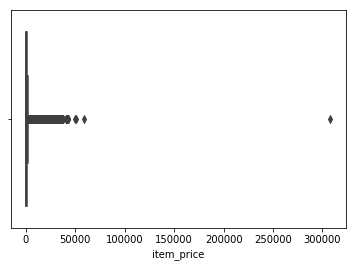

In [6]:
sns.boxplot(sales['item_price'])

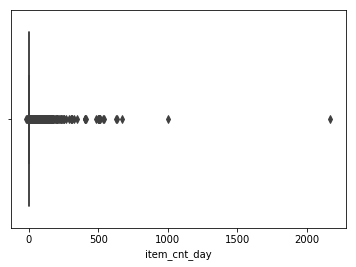

In [8]:
sns.boxplot(sales.item_cnt_day)

###### Removing outliers from sales 

In [113]:
sales = sales[sales.item_cnt_day<1000]
sales = sales[sales.item_price<100000]
sales = sales[sales.item_price>0]

#### Exploratory Data Analysis

The possible amount of item/shop combinations is much lower than total possible combinations 

In [11]:
sales[['item_id','shop_id']].drop_duplicates().shape[0]/(sales.item_id.nunique()*sales.shop_id.nunique())

0.3241638386988291

Test set has a higher percentage of all combinations of item-shop pairs, more evindence that it is generated by taking all pairs.
Guess: 
* Train set generated by actual items bought in shops in the past few years. 
* Test set generated by taking all combinations of item-shop pairs. (0.7 of them in public test dataset,private mostly remaining 0.3)

In [12]:
test[['item_id','shop_id']].drop_duplicates().shape[0]/(test.item_id.nunique()*sales.shop_id.nunique())

0.7

##### Most of the item_prices are between 0-10,000

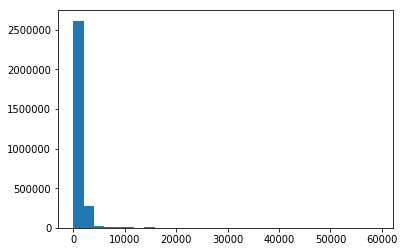

In [11]:
plt.hist(sales.item_price,bins=30)
plt.show()

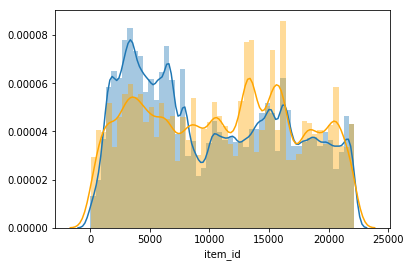

In [18]:
plt.figure()
sns.distplot(sales.item_id,hist=True)
sns.distplot(test.item_id,hist=True,color='orange')

There are many new items in test set (363)

In [15]:
len(list(set(test.item_id)-set(sales.item_id)))

363

In [16]:
len(list(set(sales.item_id)-set(test.item_id)))

17069

Same shops, but new items, so many predictions will be zero in the test set, because new items. Test set generated by taking shop item pairs? Validation strategy grid of all possible combinations good, already got it but trying to understand the process.


In [14]:
len(list(set(test.shop_id)-set(sales.shop_id)))

0

In [27]:
test.shop_id.nunique(),test.item_id.nunique(),42*5100,test.shape[0]

(42, 5100, 214200, 214200)

Test set structure:
* There are 42 shops which are all present in the train dataset 
* there are 5100 items out of which 363 items are new. 
* so test is just combinations of all of these so 42 X 5100 = 21420 datapoints. 
* Public test has 70% of all combinations and private is (guess) the other 30%

### Feature Engineering 
* Add item/shop month aggregates(done)
* Add revenue for shops (done)
* Add shop names and item categories(done) 
* Extract city name(done) or some info from shop names 
* Add expensive variable (cheap,mid-range,expensive)
* Prepare Grid and merge with grouped aggregates (Validation strategy)(done)
* Number of holidays in that month(done)
* Add month(done)
* Add Lag Features (done)
* Add Trends
 * averages for the past 1,3,6,12 months 
     * shop_target
     * item_target
     * target
* Mean encode all these features 


##### Month agregates for item-shop, item,shop

In [114]:
index_cols = ['shop_id','item_id','date_block_num']

grid=[]

for block_num in sales.date_block_num.unique():
    curr_shops = sales.loc[sales['date_block_num']==block_num,'shop_id'].unique()
    curr_items = sales.loc[sales['date_block_num']==block_num,'item_id'].unique()
    grid.append(np.array(list(product(*[curr_shops,curr_items,[block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid),columns = index_cols,dtype=np.int32)

# Grouping data to get all item/shop-month agrregates 

gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]


all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)

# Now groupby data to get all shop_month agregate

gb = sales.groupby(['shop_id','date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]

all_data = pd.merge(all_data,gb,how='left',on=['shop_id','date_block_num']).fillna(0)



# Now groupby data to get item_month aggregates 

gb = sales.groupby(['item_id','date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]

all_data = pd.merge(all_data,gb,how='left',on=['item_id','date_block_num']).fillna(0)

#Downcasting to save memory 64 to 32 bit 
all_data = downcast_dtypes(all_data)
del grid,gb
gc.collect();


## Combining Test set to all_data for feature engineering 

In [119]:
test['date_block_num'] = 34
all_data = pd.concat([all_data,test],ignore_index=True,keys=index_cols)
all_data.drop(['ID'],axis=1,inplace=True)
all_data.fillna(0,inplace=True)

### Adding revenue 

In [17]:
#all_data = pd.merge(all_data,sales[['item_id','shop_id','date_block_num','item_price']],how='left',on=index_cols).fillna(0)
#all_data['revenue_item_month'] = all_data.target_item*all_data.item_price
#all_data.drop(['item_price'],axis=1,inplace=True)

#### Adding lag features for 1,3,6,12 months

In [27]:
#Creating lag features 

#list of columns we will use to create lag features 
"""
col_to_rename = list(all_data.columns.difference(index_cols))

shift_range = [1,3,6,12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols+col_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num']+month_shift
    foo = lambda x: '{}_lag_{}'.format(x,month_shift) if x in col_to_rename else x
    train_shift = train_shift.rename(columns=foo) 
    all_data = pd.merge(all_data,train_shift,how='left',on=index_cols).fillna(0)

del train_shift

# Not using old data from 2013 
all_data = all_data[all_data['date_block_num']>=12]

fit_cols  = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
to_drop_cols = list(set(list(all_data.columns))-(set(fit_cols)|set(index_cols))) + ['date_block_num']

# Map Category to items 
item_cat = items[['item_id','item_category_id']].drop_duplicates()

all_data  = pd.merge(all_data,item_cat,how='left',on='item_id')

all_data = downcast_dtypes(all_data)
gc.collect();"""



"\ncol_to_rename = list(all_data.columns.difference(index_cols))\n\nshift_range = [1,3,6,12]\n\nfor month_shift in tqdm_notebook(shift_range):\n    train_shift = all_data[index_cols+col_to_rename].copy()\n    train_shift['date_block_num'] = train_shift['date_block_num']+month_shift\n    foo = lambda x: '{}_lag_{}'.format(x,month_shift) if x in col_to_rename else x\n    train_shift = train_shift.rename(columns=foo) \n    all_data = pd.merge(all_data,train_shift,how='left',on=index_cols).fillna(0)\n\ndel train_shift\n\n# Not using old data from 2013 \nall_data = all_data[all_data['date_block_num']>=12]\n\nfit_cols  = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]\nto_drop_cols = list(set(list(all_data.columns))-(set(fit_cols)|set(index_cols))) + ['date_block_num']\n\n# Map Category to items \nitem_cat = items[['item_id','item_category_id']].drop_duplicates()\n\nall_data  = pd.merge(all_data,item_cat,how='left',on='item_id')\n\nall_data = downcast_dtyp

### Going to add shop names and extract information from text 

In [127]:
shop_name = shops.copy()
shop_name['city'] = shop_name['shop_name_translated'].apply(lambda x: x.split()[0])
shop_name.drop(['shop_name_translated'],axis=1,inplace=True)
all_data = pd.merge(all_data,shop_name,how='left',on=['shop_id'])


#### Label Encoding city 

In [128]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
all_data.city = le.fit_transform(all_data.city)

### Adding item_categories

In [129]:
item_cat = items[['item_id','item_category_id']].drop_duplicates()
all_data  = pd.merge(all_data,item_cat,how='left',on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();


In [130]:
all_data.head()

,date_block_num,item_id,shop_id,target,target_item,target_shop,city,item_category_id
0,0,22154,59,1.0,18.0,2017.0,31,37
1,0,2552,59,0.0,0.0,2017.0,31,58
2,0,2554,59,0.0,1.0,2017.0,31,58
3,0,2555,59,0.0,2.0,2017.0,31,56
4,0,2564,59,0.0,5.0,2017.0,31,59


### Saving this pure dataframe before encoding and lag features 

In [131]:
pure_data = HDFStore('all_data_pure.h5')
pure_data.put('all_data_pure',all_data,format='table',data_columns=True)

### Mean Encoding Stuff 


#### Using expanding mean regularization 
* First split train/validation X_tr,X_val
* estimate encodings of X_tr and map to X_tr and X_val
* validate model using X_val
* estimate encodings of train and map to train and test 


Testing function to encode 

In [137]:
all_data1 = all_data.copy()

### Writing function to encode features 

In [138]:
def mean_encode_features(feature_list,df):
    for feature in feature_list:
        enc = df.groupby(feature).agg({'target':['mean']})
        enc.columns = ['{}_encoded'.format('_'.join(feature))]
        enc.reset_index(inplace=True)
        df = pd.merge(df,enc,how='left',on=feature)
    del enc
    gc.collect();
    return df
    

### Mean Encoding Features 

In [139]:
feature_list = [['date_block_num'],['date_block_num','shop_id'],['date_block_num','item_id'],['date_block_num','city'],
                ['date_block_num','item_category_id'],['date_block_num','shop_id','item_category_id']]

In [140]:
all_data1=mean_encode_features(feature_list,all_data1)

In [82]:
"""X_train = mean_encode_features(feature_list,X_train)
X_32 = X_train[X_train.date_block_num==32]
X_32['date_block_num'] = 33
enc_feat = [col for col in X_32.columns if 'encoded' in col.split('_')]
X_32 = X_32[index_cols + enc_feat]
X_val = pd.merge(X_val,X_32,how='left',on=index_cols).fillna(0)"""

### Saving Encoded dataset 

In [150]:
encoded_train_test = HDFStore('encoded_train_test.h5')
encoded_train_test.put('encoded_train_test',all_data1,format='table',data_columns=True)


### Creating Lag features for all 
* Combining train and val to get lag features 

In [83]:
"""combine = [X_train,X_val]
all_data2 = pd.concat(combine)"""

In [146]:
all_data2 = all_data1.copy()

##### Defining functions to create lag features

In [147]:
def lag_features_func(lag_features,time_range,df,non_lag_features):
    for month_shift in tqdm_notebook(time_range):
        shift_df = df[non_lag_features+lag_features].copy()
        shift_df['date_block_num'] = shift_df['date_block_num'] + month_shift
        foo = lambda x: '{}_lag_{}'.format(x,month_shift) if x in lag_features else x
        shift_df = shift_df.rename(columns=foo)
        df = pd.merge(df,shift_df,how='left',on=non_lag_features).fillna(0)
    del shift_df
    gc.collect();
    
    return df
    

Creating Lag features 

In [148]:
lag_features = [col for col in all_data1.columns if (('target' in col.split('_'))|('encoded' in col.split('_')))]
non_lag_features = list(all_data1.columns.difference(lag_features))
time_range = [1,2,3,6,12]


In [149]:
all_data2 = lag_features_func(lag_features,time_range,all_data2,non_lag_features)
all_data2 = all_data2[all_data2.date_block_num>=12]

MemoryError: 

###  Debugged problem

* most lag features were all NaN, the mistake was creating month columns before creating lag features.
* Since it's basically the date_block_num while merging it didn't align with previous values 

#### Adding supplementary information
* Add Month (done)
* Add number of holidays (national holidays)(done)
* Add season (optional)


In [92]:
calendar['month'] = calendar.date.apply(lambda x: int(x.split('-')[1]))
gp = calendar.groupby('month').agg({'holiday':{'holidays_in_month':'sum'}})
gp.columns = [col[0] if col[-1]=='' else col[-1] for col in gp.columns.values]
all_data2['month'] = all_data2.date_block_num.apply(lambda block: (block%12) +1)
all_data2 = pd.merge(all_data2,gp,how='left',on=['month'])
del gp
gc.collect();

In [ ]:
all_data2.head()

In [96]:
store = HDFStore('all_data_encoded_lag.h5')
store.put('all_data_encoded_lag.h5',all_data2,format='table',data_columns=True)

# Modelling 
* Using Lightgbm to train models 
* validation set is the last month


### Stuff to do 
* Use mean_encodings of train and map to validation (done)
* Prepare test set 
* tune model 
* Clip predictions and figure out when and how to do it 

In [105]:
dates = all_data2['date_block_num']
last_block = dates.max()

dates_train = dates[dates<last_block]
dates_val = dates[dates==last_block]
present_encoded = [col for col in all_data2.columns if col.split('_')[-1]=='encoded']
X_train = all_data2.loc[dates<last_block].drop(['target','target_shop','target_item']+present_encoded,axis=1)
X_val = all_data2.loc[dates==last_block].drop(['target','target_shop','target_item'],axis=1)

y_train = all_data2.loc[dates<last_block,'target'].values
y_val = all_data2.loc[dates==last_block,'target'].values

### Preparing test 

In [107]:
test['date_block_num']=34

In [108]:
X_train.head()

,shop_id,item_id,date_block_num,city,item_category_id,target_lag_1,target_shop_lag_1,target_item_lag_1,date_block_num_encoded_lag_1,date_block_num_shop_id_encoded_lag_1,date_block_num_item_id_encoded_lag_1,date_block_num_city_encoded_lag_1,date_block_num_item_category_id_encoded_lag_1,date_block_num_shop_id_item_category_id_encoded_lag_1,target_lag_2,target_shop_lag_2,target_item_lag_2,date_block_num_encoded_lag_2,date_block_num_shop_id_encoded_lag_2,date_block_num_item_id_encoded_lag_2,date_block_num_city_encoded_lag_2,date_block_num_item_category_id_encoded_lag_2,date_block_num_shop_id_item_category_id_encoded_lag_2,target_lag_3,target_shop_lag_3,...,date_block_num_shop_id_encoded_lag_3,date_block_num_item_id_encoded_lag_3,date_block_num_city_encoded_lag_3,date_block_num_item_category_id_encoded_lag_3,date_block_num_shop_id_item_category_id_encoded_lag_3,target_lag_6,target_shop_lag_6,target_item_lag_6,date_block_num_encoded_lag_6,date_block_num_shop_id_encoded_lag_6,date_block_num_item_id_encoded_lag_6,date_block_num_city_encoded_lag_6,date_block_num_item_category_id_encoded_lag_6,date_block_num_shop_id_item_category_id_encoded_lag_6,target_lag_12,target_shop_lag_12,target_item_lag_12,date_block_num_encoded_lag_12,date_block_num_shop_id_encoded_lag_12,date_block_num_item_id_encoded_lag_12,date_block_num_city_encoded_lag_12,date_block_num_item_category_id_encoded_lag_12,date_block_num_shop_id_item_category_id_encoded_lag_12,month,holidays_in_month
0,54,10297,12,7,37,3.0,10055.0,42.0,0.470397,1.186711,0.913043,1.186711,0.234054,0.601081,0.0,7978.0,2.0,0.357163,0.986278,0.044444,0.986278,0.183823,0.599777,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,19
1,54,10296,12,7,38,0.0,10055.0,24.0,0.470397,1.186711,0.521739,1.186711,0.243763,0.551913,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,19
2,54,10298,12,7,40,21.0,10055.0,369.0,0.470397,1.186711,8.021739,1.186711,0.309148,0.952263,119.0,7978.0,1309.0,0.357163,0.986278,29.088888,0.986278,0.264596,0.991105,7.0,6676.0,...,0.830452,3.130435,0.830452,0.254233,0.847121,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,19
3,54,10300,12,7,37,1.0,10055.0,54.0,0.470397,1.186711,1.173913,1.186711,0.234054,0.601081,31.0,7978.0,361.0,0.357163,0.986278,8.022223,0.986278,0.183823,0.599777,0.0,6676.0,...,0.830452,1.152174,0.830452,0.171495,0.559591,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,19
4,54,10284,12,7,57,0.0,10055.0,4.0,0.470397,1.186711,0.086957,1.186711,0.138296,0.455357,0.0,7978.0,3.0,0.357163,0.986278,0.066667,0.986278,0.104563,0.388393,0.0,6676.0,...,0.830452,0.108696,0.830452,0.112876,0.408654,1.0,7225.0,9.0,0.302527,0.859607,0.195652,0.859607,0.123188,0.513726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,19


In [43]:
lgb_params = {
                'feature_fraction':0.75,
                'metric':'rmse',
                'nthread':3,
                'min_data_in_leaf':2**7,
                'bagging_fraction':0.75,
                'learning_rate':0.25,
                'objective':'mse',
                'bagging_seed':2**7,
                'max_depth':20,
                'num_leaves':2**9,
                'bagging_freq':1,
                'verbose':0
            }

model = lgb.train(lgb_params,lgb.Dataset(X_train,label=y_train),num_boost_round=200)
pred_lgb_val = model.predict(X_val)
pred_lgb_tr = model.predict(X_train)


print('Validation Rmse for LightGBM is %f'% np.sqrt( mean_squared_error(y_val,pred_lgb_val)))
print('Validation R-squared for LightGBM is %f'% r2_score(y_val,pred_lgb_val))
print('Train Rmse for LightGBM is %f'% np.sqrt(mean_squared_error(y_train,pred_lgb_tr)))
print('Train R-squared for LightGBM is %f'% r2_score(y_train,pred_lgb_tr))


Validation Rmse for LightGBM is 1.504901
Validation R-squared for LightGBM is 0.688375
Train Rmse for LightGBM is 1.378761
Train R-squared for LightGBM is 0.845588


In [42]:
all_data1.date_block_num.max()

33